## Incendios en Villa Albertina - Sentinel 2

Observamos las imagenes de sentinel 2 respecto a los [incendios](https://www.cadena3.com/noticia/radioinforme-3/continua-el-combate-del-incendio-en-villa-albertina_268066) en Villa Albertina.

Recordamos las especificaciones de las bandas:

| Banda | Central Wavelenght | Resolution [m] |
|---|---|---|
|1  - Coastal aerosol|  443  |  60 |
|2  - Blue|  490  |  10 |
|3  - Green|  560  |  10 |
|4  - Red|  665  |  10 |
|5  - Vegetation Red Edge|  705  |  20 |
|6  - Vegetation Red Edge|  740  |  20 |
|7  - Vegetation Red Edge|  783  |  20 |
|8  - NIR|  842  |  10 |
|8a - Vegetation Red Edge|  865  |  20 |
|9  - Water vapour|  945  |  60 |
|10 - SWIR Cirrus|  1380 |  60 |
|11 - SWIR|  1610 |  20 |
|12 - SWIR |  2190 |  20 |

Tenemos que trabajar con varias de ellas y estan en distinta resolucion, por lo cual vamos a resamplear las que correspondan. En general vamos a trabajar a 20 m y las que utilizariamos serian 2,3,4,8,11,12.

In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import tempfile
import zipfile
import rasterio as rio
from rasterio.mask import mask
import shutil
from rasterio import plot
import glob
import gdal

### Data, Products and Temps

In [2]:
# from http://geojson.io/#map=11/-30.5995/-64.2055
vector_file='data/villa_albertina.geojson'
# images from https://scihub.copernicus.eu using sentinelsat api
zip_20200815='data/S2A_MSIL2A_20200815T141741_N0214_R010_T20JLM_20200815T182929.zip'
zip_20200817='data/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM_20200817T163953.zip'

In [3]:
products='products'
os.makedirs(products,exist_ok=True)
products_tmp=os.path.join(products,'tmp')
os.makedirs(products_tmp,exist_ok=True)

In [4]:
class bands_etl(object):
    """
        
    """
    
    @staticmethod
    def get_ndi(band_1,band_2,weight=[1.0,1.0],dtype=rio.float32,nodata=-10000):
        ndi = (weight[0]*band_1.astype(float)-weight[1]*band_2.astype(float))/(band_1*weight[0]*+band_2*weight[1])
        ndi_val=np.where((band_1*weight[0]*+band_2*weight[1])>0,ndi,nodata)
        
        return ndi_val.astype(dtype)
    
    @staticmethod
    def get_band_paths(path_,pattern_=['*_10m.jp2']):
        """
        """
        names_bands={}
        all_names_bands={}
        for root, _, _ in os.walk(path_):
            for p in pattern_:
                ret=glob.glob(root+os.path.sep+p)
                if len(ret)>0:
                    j=0
                    for r in ret:
                        full_path=os.path.join(root, r)
                        name=os.path.basename(full_path)
                        band=name.split('_')[-2]
                        c={band:full_path}
                        names_bands.update(c)
                        all_names_bands.update({p+'_'+str(j):full_path})
                        j+=1
                else:
                    pass
        return names_bands,all_names_bands
    
    @staticmethod
    def basic_resampling(input_raster,output_raster,resampling_method='cubic',cell_size=20):
        """
        :param input_raster: file to be resampled
        :param output_raster: file to be written
        """
        warp_opts = [
            "-r",
            resampling_method,
            "-tr",
            str(cell_size),
            str(cell_size),
        ]
        #
        gdal.UseExceptions()
        ds = gdal.Warp(output_raster, input_raster, options=warp_opts)  # noqa
        del ds
    
    def set_band_names(self,band_dict):
        """
        :param band_dict: dict with band names and paths
        """
        self.band_names_=band_dict
        
    def get_band(self,b,open_flag):
        """
        """
        if open_flag:
            band_=rio.open(self.band_names_[b])
        else:
            band_=b
        return band_
    
    def set_mask_from_gpd(self,mask_gpd_geometry):
        """
        """
        self.mask_gpd_geom_=mask_gpd_geometry
    
      
    def get_clipping_params(self,band_init,mask_opts={'crop':True},open_flag=True):
        """
        """
        band_=self.get_band(band_init,open_flag)
        out_image_init, out_transform_init = mask(band_, self.mask_gpd_geom_,**mask_opts)
        self.image_shape_0_=out_image_init[0].shape[0]
        self.image_shape_1_=out_image_init[0].shape[1]
        self.transform_=out_transform_init
        self.dtype_=out_image_init[0].dtype
        self.crs_=band_.crs
        
    def bands_clipped_to_tiff(self,bands_list,tiff_name_='bands.tiff',driver_='Gtiff',open_flag=True,scale_band=False):
        # Create an RGB image 
        if scale_band:
            dtype_=rio.float32
        else:
            dtype_=self.dtype_
        
        
        with rio.open(tiff_name_,'w',driver=driver_, width=self.image_shape_1_, height=self.image_shape_0_, 
              count=len(bands_list),crs=self.crs_,transform=self.transform_, dtype=dtype_) as img:
    
            for i,b in enumerate(bands_list,start=1):
                band_=self.get_band(b,open_flag)
                out_image_init, out_transform_init = mask(band_, self.mask_gpd_geom_,crop=True)
                if scale_band:
                    res=out_image_init[0]/out_image_init[0].max()
                    img.write(res.astype(dtype_),i)
                else:
                    img.write(out_image_init[0],i)
                #
                band_.close()
                out_image_init=None
                out_transform_init=None
            img.close()
    
    
    def ndi_to_tiff(self,band1_,band2_,weight=[1.0,1.0],tiff_name_='ndi.tiff',driver_='Gtiff',open_flag=True,nodata=-10000):
        # Create an NDVI image 
        with rio.open(tiff_name_,'w',driver=driver_, width=self.image_shape_0_, height=self.image_shape_1_, 
              count=1,crs=self.crs_,transform=self.transform_, dtype=rio.float32,nodata=nodata) as img:
            band2_init=self.get_band(band2_,open_flag)
            band1_init=self.get_band(band1_,open_flag)
            band2, _ = mask(band2_init, self.mask_gpd_geom_,crop=True)
            band1, _ = mask(band1_init,  self.mask_gpd_geom_,crop=True)
            band2_init.close()
            band1_init.close()
            img.write(self.get_ndi(band1,band2,weight,nodata=nodata))
            img.close()
            
            
def write_array_single(
    input_filename,
    output_filename,
    array,
    array_dtype=rio.uint8,
    nodata_=0,
    attribs_source_="profile",
):
    """
    :param input_filename: input filename (vrt,tiff,etc) to be taken as src for profile
    :param output_filename: output filename
    :param array: numpy array to be written
    :param array_dtype: rasterio or numpy dtype
    :param nodata_: nodata to be written as integer (e.g.:-10000)
    :param attribs_source_: meta or profile
    """

    with rio.open(input_filename) as src:

        attribs_ = getattr(src, attribs_source_)
        # update meta
        attribs_.update(
            dtype=array_dtype,
            count=1,
            driver="GTiff",
            nodata=nodata_,
            compresion="lzw",
        )

        with rio.open(output_filename, "w", **attribs_) as dst:
            dst.write(array.astype(array_dtype), 1)

### Vector file proc

Incorporamos el archivo vectorial y lo referenciamos en el epsg correspondiente.

In [5]:
gpd_va=gpd.read_file(vector_file)
gpd_va_proj = gpd_va.to_crs(epsg=32720)
#
gpd_vt=gpd.read_file('data/villa_del_totoral.geojson')
gpd_vt_proj = gpd_vt.to_crs(epsg=32720)


### Images proc

Procesamos las imagenes

In [6]:
cases_dict={}
#
file=zip_20200817
dirtmp=tempfile.mkdtemp()
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall(dirtmp)

In [7]:
# instanciamos el proc
bp=bands_etl()
# incluimos la capa vectorial
bp.set_mask_from_gpd(gpd_va_proj.geometry)
# Obtenemos los paths
paths,_=bp.get_band_paths(dirtmp, pattern_=['*B0?_10m.jp2','*B1?_20m.jp2'])
paths

{'B02': '/tmp/tmp4026xaso/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM_20200817T163953.SAFE/GRANULE/L2A_T20JLM_A018011_20200817T141049/IMG_DATA/R10m/T20JLM_20200817T141049_B02_10m.jp2',
 'B03': '/tmp/tmp4026xaso/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM_20200817T163953.SAFE/GRANULE/L2A_T20JLM_A018011_20200817T141049/IMG_DATA/R10m/T20JLM_20200817T141049_B03_10m.jp2',
 'B04': '/tmp/tmp4026xaso/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM_20200817T163953.SAFE/GRANULE/L2A_T20JLM_A018011_20200817T141049/IMG_DATA/R10m/T20JLM_20200817T141049_B04_10m.jp2',
 'B08': '/tmp/tmp4026xaso/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM_20200817T163953.SAFE/GRANULE/L2A_T20JLM_A018011_20200817T141049/IMG_DATA/R10m/T20JLM_20200817T141049_B08_10m.jp2',
 'B11': '/tmp/tmp4026xaso/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM_20200817T163953.SAFE/GRANULE/L2A_T20JLM_A018011_20200817T141049/IMG_DATA/R20m/T20JLM_20200817T141049_B11_20m.jp2',
 'B12': '/tmp/tmp4026xaso/S2B_MSIL2A_20200817T141049_N0214_R110_T20JLM

In [8]:
# Debido a las diferencias en el pixel size de la bandas debemos resamplear
resampled_bands={}
for band in paths:
    case='_20200817_Resampled'
    name=os.path.join(products_tmp,band+case)
    resampled_bands.update({band:name})
    bp.basic_resampling(paths[band],name)
#
shutil.rmtree(dirtmp)
# seteamos las bandas
bp.set_band_names(resampled_bands)

In [9]:
# Generamos los parametros para el recorte
bp.get_clipping_params('B02')

In [10]:

case='false_color_urban_20200817.tiff'
tiff_name_=os.path.join(products,case)
bp.bands_clipped_to_tiff(['B12','B11','B04'],tiff_name_=tiff_name_,scale_band=True)
cases_dict.update({case:tiff_name_})
#
case='false_color_urban_20200817_NOTScaled.tiff'
tiff_name_=os.path.join(products,case)
bp.bands_clipped_to_tiff(['B12','B11','B04'],tiff_name_=tiff_name_,scale_band=False)
cases_dict.update({case:tiff_name_})

#
case='rgb_20200817.tiff'
tiff_name_=os.path.join(products,case)
bp.bands_clipped_to_tiff(['B04','B03','B02'],tiff_name_=tiff_name_,scale_band=True)
cases_dict.update({case:tiff_name_})
#
case='rgb_20200817_NOTSCaled.tiff'
tiff_name_=os.path.join(products,case)
bp.bands_clipped_to_tiff(['B04','B03','B02'],tiff_name_=tiff_name_,scale_band=False)
cases_dict.update({case:tiff_name_})


Visualizamos

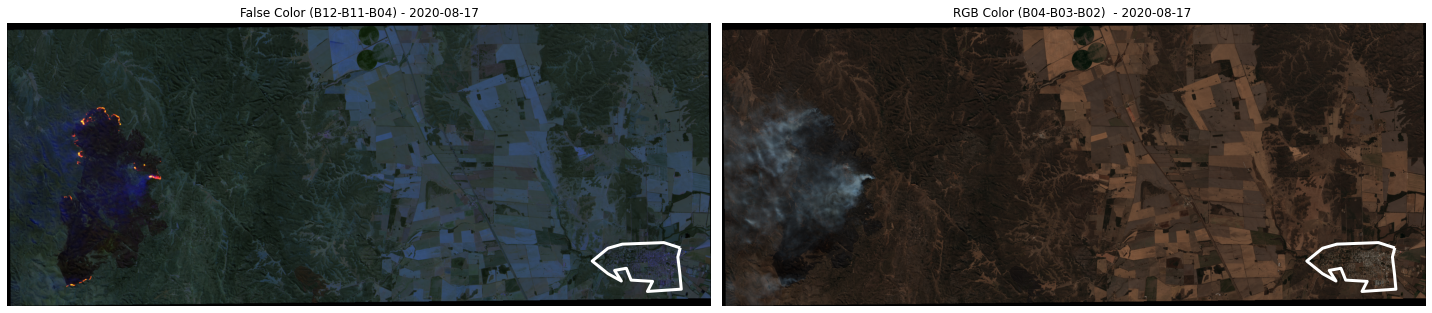

In [11]:
f,ax=plt.subplots(1,2,figsize=(20,10))
r=rio.open(cases_dict['false_color_urban_20200817.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax[0])
ax[0].set_title('False Color (B12-B11-B04) - 2020-08-17')
gpd_vt_proj.plot(ax=ax[0],facecolor='None',edgecolor='white',lw=3)
ax[0].axis('off')
#
r=rio.open(cases_dict['rgb_20200817.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax[1])
ax[1].set_title('RGB Color (B04-B03-B02)  - 2020-08-17 ')
gpd_vt_proj.plot(ax=ax[1],facecolor='None',edgecolor='white',lw=3)
ax[1].axis('off')
plt.tight_layout()
plt.savefig(products+os.sep+'img_fc_rgb.png',dpi=300,transparent=True)

In [12]:
file=zip_20200815
dirtmp=tempfile.mkdtemp()
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall(dirtmp)
    
# instanciamos el proc
bp=bands_etl()
# incluimos la capa vectorial
bp.set_mask_from_gpd(gpd_va_proj.geometry)
# Obtenemos los paths
paths,_=bp.get_band_paths(dirtmp, pattern_=['*B0?_10m.jp2','*B1?_20m.jp2'])
paths
#
# Debido a las diferencias en el pixel size de la bandas debemos resamplear
resampled_bands={}
for band in paths:
    case='_20200815_Resampled'
    name=os.path.join(products_tmp,band+case)
    resampled_bands.update({band:name})
    bp.basic_resampling(paths[band],name)

shutil.rmtree(dirtmp)
# seteamos las bandas
bp.set_band_names(resampled_bands)
# Generamos los parametros para el recorte
bp.get_clipping_params('B02')
#
case='false_color_urban_20200815.tiff'
tiff_name_=os.path.join(products,case)
bp.bands_clipped_to_tiff(['B12','B11','B04'],tiff_name_=tiff_name_,scale_band=True)
cases_dict.update({case:tiff_name_})
#
case='rgb_20200815.tiff'
tiff_name_=os.path.join(products,case)
bp.bands_clipped_to_tiff(['B04','B03','B02'],tiff_name_=tiff_name_,scale_band=True)
cases_dict.update({case:tiff_name_})

Visualizamos

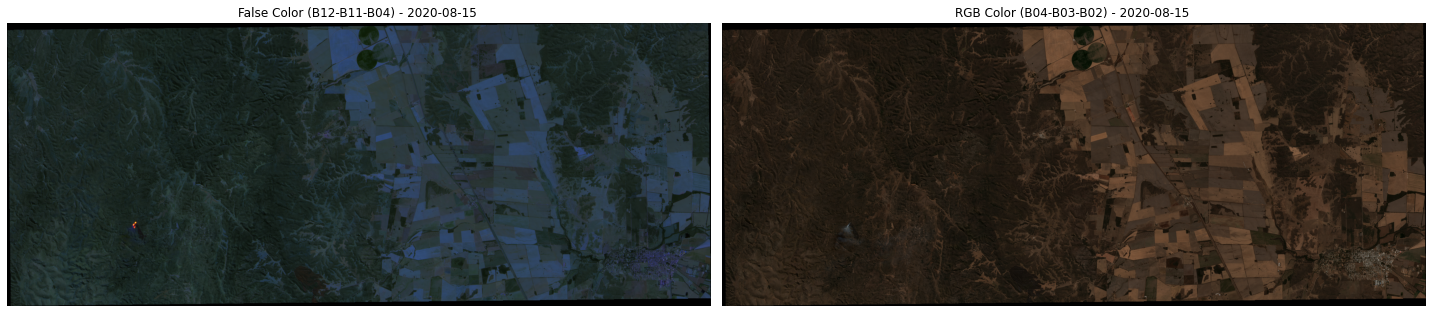

In [13]:
f,ax=plt.subplots(1,2,figsize=(20,10))
r=rio.open(cases_dict['false_color_urban_20200815.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax[0])
ax[0].set_title('False Color (B12-B11-B04) - 2020-08-15 ')
ax[0].axis('off')
#
r=rio.open(cases_dict['rgb_20200815.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax[1])
ax[1].set_title('RGB Color (B04-B03-B02) - 2020-08-15 ')
ax[1].axis('off')
plt.tight_layout()
plt.savefig(products+os.sep+'img_fc_rgb_20200815.png',dpi=300,transparent=True)

Ahora vamos a estimar (en forma muy aproximada) el area afectada. Para ello nos valemos de la banda 11. Vemos que es la que mayor contraste parece tener

<AxesSubplot:>

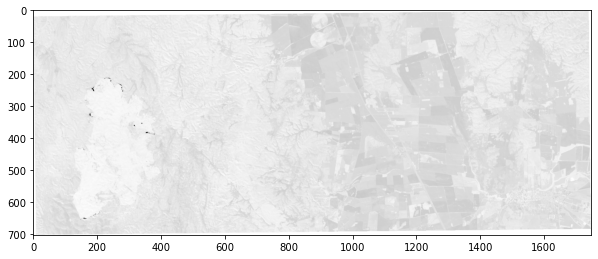

In [14]:
f,ax=plt.subplots(1,1,figsize=(10,10))
r=rio.open(cases_dict['false_color_urban_20200817.tiff'])
plot.show(r.read(2),ax=ax,cmap='Greys')

In [15]:
check_file = lambda path:  os.remove(path) if os.path.isfile(path) else None

In [16]:
file_path_threshold=os.path.join(products_tmp,'thresholding_b11.tif')
check_file(file_path_threshold)
!gdal_calc.py --calc="A>1400" -A 'products/false_color_urban_20200817_NOTScaled.tiff' --A_band=2 --outfile={file_path_threshold} --quiet

<AxesSubplot:>

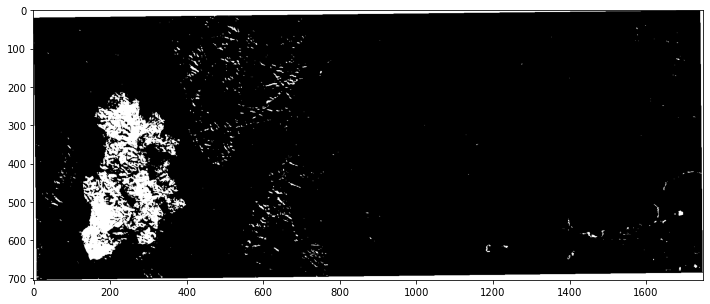

In [17]:
f,ax=plt.subplots(1,1,figsize=(12,12))
r=rio.open(file_path_threshold)
plot.show(r.read(1),cmap='Greys',ax=ax)

Vemos que si bien remarcamos la mayoria de la zona, quedan algunas extras. Las intentamos remover.

In [18]:
file_path_sieved=os.path.join(products_tmp,'thresholding_b11_sieved.tif')
check_file(file_path_sieved)
!gdal_sieve.py {file_path_threshold} {file_path_sieved} -st 10

0...10...20...30...40...50...60...70...80...90...100 - done.


<AxesSubplot:>

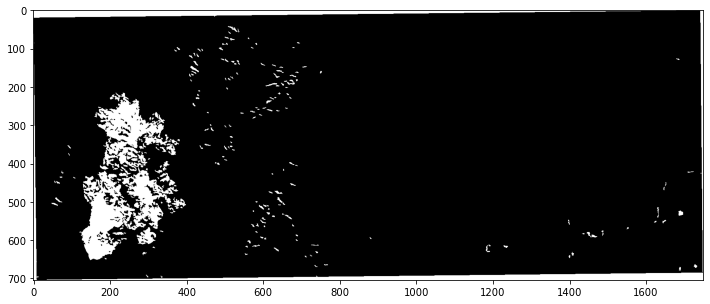

In [19]:
f,ax=plt.subplots(1,1,figsize=(12,12))
r=rio.open(file_path_sieved)
plot.show(r.read(1),cmap='Greys',ax=ax)

<AxesSubplot:>

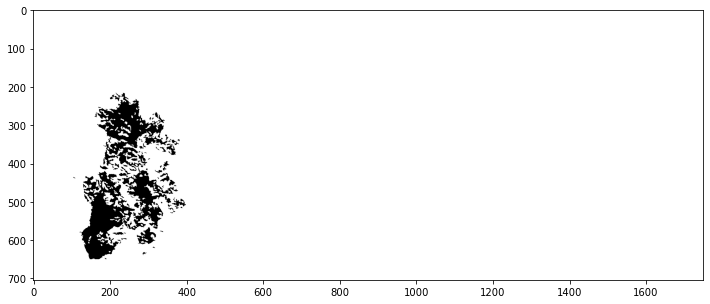

In [20]:
# Las zonas blancas en los bordes nos van a molestar, asique nos "ensuciamos las manos"
fire=np.ones(r.read(1).shape)
fire[200:650,100:400]=r.read(1)[200:650,100:400]
fire=np.where(fire==0,1,0)
f,ax=plt.subplots(1,1,figsize=(12,12))
plot.show(fire,cmap='Greys',ax=ax)

In [21]:
raster_to_shape=os.path.join(products_tmp,'raster_to_shape.tif')
write_array_single(file_path_sieved,raster_to_shape,fire)

In [22]:
vector_fire_sieved=os.path.join(products_tmp,'fire_shape.shp')
!gdal_polygonize.py {raster_to_shape} {vector_fire_sieved}

Creating output products/tmp/fire_shape.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
gpd_fire=gpd.read_file(vector_fire_sieved)

Visualizamos el conjunto

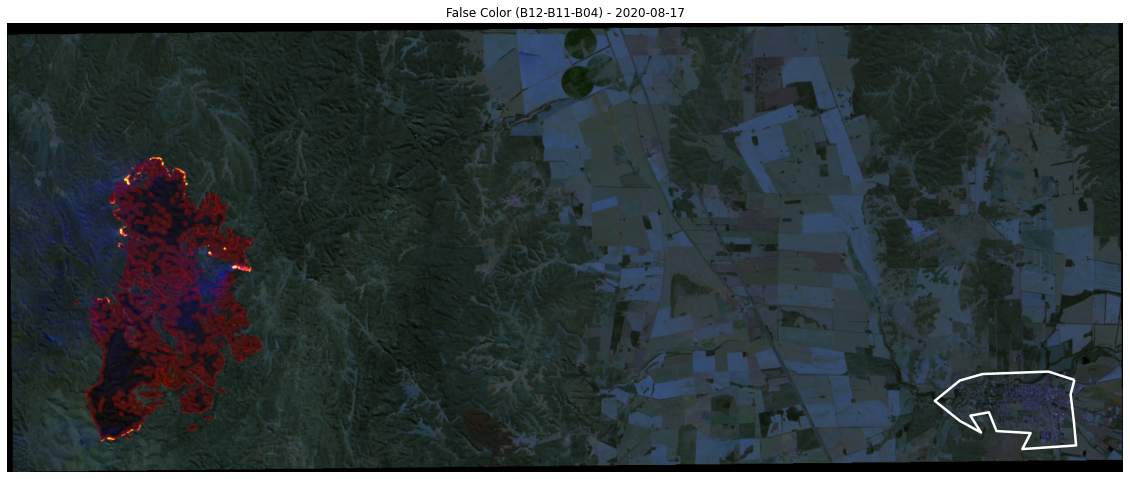

In [24]:
f,ax=plt.subplots(1,1,figsize=(20,10))
r=rio.open(cases_dict['false_color_urban_20200817.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax,title='PEPE')
ax.set_title('False Color (B12-B11-B04) - 2020-08-17')
ax.axis('off')
gpd_fire.plot(ax=ax,facecolor='None',edgecolor='red',lw=3,alpha=0.2)
gpd_vt_proj.plot(ax=ax,facecolor='None',edgecolor='white',lw=2.5)
plt.savefig(products+os.sep+'img_fc_shape_detailed.png',dpi=300,transparent=True)

In [25]:
vt_hectareas=(gpd_vt_proj.area/100**2)[0]
fuego_hectareas=(gpd_fire.area/100**2).sum()

In [26]:
resume=products+os.sep+'resume.txt'
with open(resume,'w') as f:
    f.write('Villa del Totoral: {}[hectareas]'.format(vt_hectareas))
    f.write('\n')
    f.write('Fuego: {}[hectareas]'.format(fuego_hectareas))

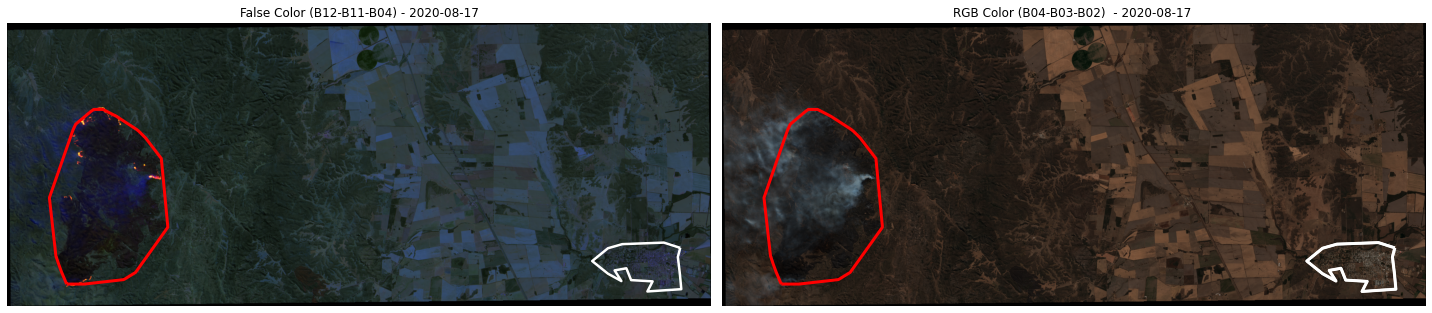

In [27]:
f,ax=plt.subplots(1,2,figsize=(20,20))
r=rio.open(cases_dict['false_color_urban_20200817.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax[0])
ax[0].set_title('False Color (B12-B11-B04) - 2020-08-17')
gpd_fire.dissolve(by='DN').convex_hull.plot(ax=ax[0],facecolor='None',edgecolor='red',lw=3)
gpd_vt_proj.plot(ax=ax[0],facecolor='None',edgecolor='white',lw=2.5)
ax[0].axis('off')
#
r=rio.open(cases_dict['rgb_20200817.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax[1])
ax[1].set_title('RGB Color (B04-B03-B02)  - 2020-08-17 ')
gpd_vt_proj.plot(ax=ax[1],facecolor='None',edgecolor='white',lw=3)
gpd_fire.dissolve(by='DN').convex_hull.plot(ax=ax[1],facecolor='None',edgecolor='red',lw=3)
gpd_vt_proj.plot(ax=ax[1],facecolor='None',edgecolor='white',lw=2.5)
ax[1].axis('off')
plt.tight_layout()


Plots

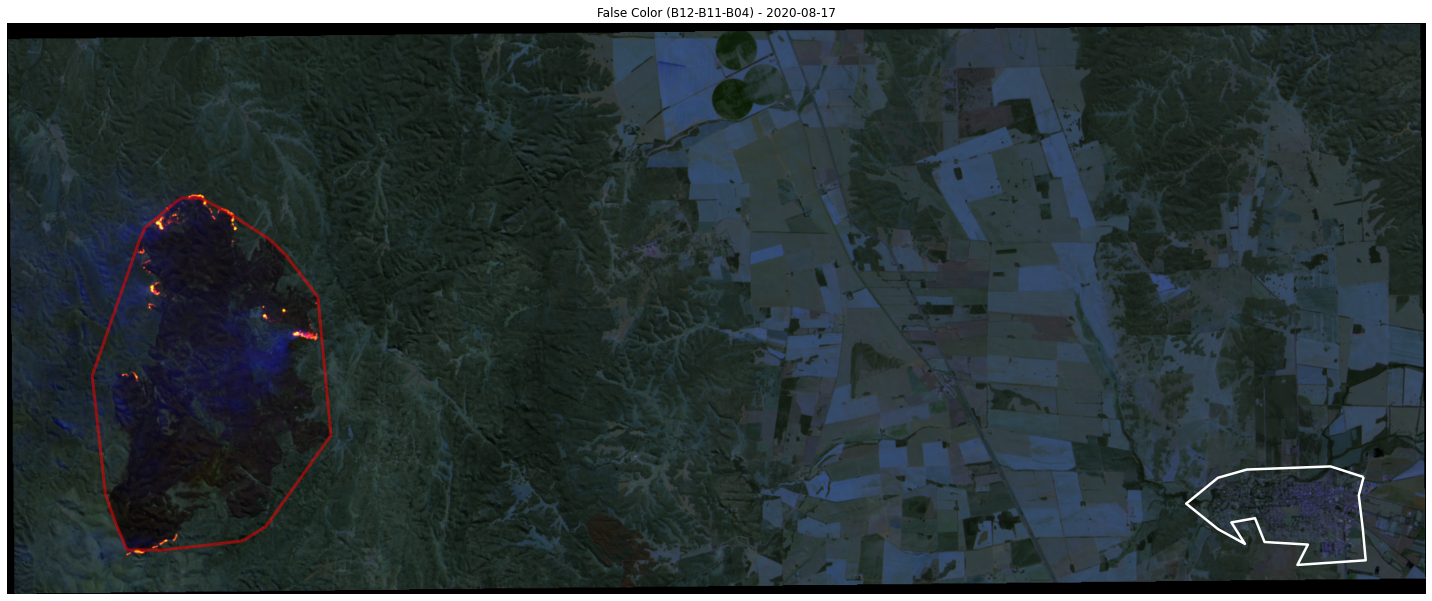

In [28]:
f,ax=plt.subplots(1,1,figsize=(20,20))
r=rio.open(cases_dict['false_color_urban_20200817.tiff'])
plot.show(r.read(),transform=r.transform,ax=ax,cmap='YlGn',adjust='linear')
ax.set_title('False Color (B12-B11-B04) - 2020-08-17')
gpd_fire.dissolve(by='DN').convex_hull.plot(ax=ax,facecolor='None',edgecolor='red',lw=3,alpha=0.5)
gpd_vt_proj.plot(ax=ax,facecolor='None',edgecolor='white',lw=2.5)
ax.axis('off')
plt.tight_layout()
plt.savefig('products/fc_simplified_shapes.png',dpi=300,transparent=True)